In [1]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [17]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0)

In [15]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive","negative"] = Field(description="Sentiment of the review")

In [5]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [6]:
structured_model = model.with_structured_output(SentimentSchema)

structure_diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [18]:
prompt = "What is the sentiment of the following review: 'The software is terrible."
response = structured_model.invoke(prompt)
print(response.sentiment)

negative


In [8]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive","negative"]
    diagnosis: dict
    response: str

In [20]:
def find_sentiment(state: ReviewState):
    prompt = f"What is the sentiment of the following review: '{state['review']}'"
    response = structured_model.invoke(prompt)
    return {"sentiment": response.sentiment}

def check_sentiment(state: ReviewState) -> Literal["run_diagnosis","positive_response"]:
    if state["sentiment"] == "negative":
        return "run_diagnosis"
    else:
        return "positive_response"
    
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt)
    return {"response": response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """

    response = structure_diagnosis_model.invoke(prompt)
    return {
        "diagnosis" : response.model_dump()
    }
def negative_response(state: ReviewState):
    diagnosis = state["diagnosis"]
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """

    response = model.invoke(prompt).content
    # text = response.content

    return {"response": response}


In [10]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment",find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("negative_response",negative_response)

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",check_sentiment)
graph.add_edge("positive_response",END)

graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)
workflow = graph.compile()


In [23]:
initial_state = {
    "review": "The software is above average."
}
final_state = workflow.invoke(initial_state)
print(final_state)

KeyboardInterrupt: 

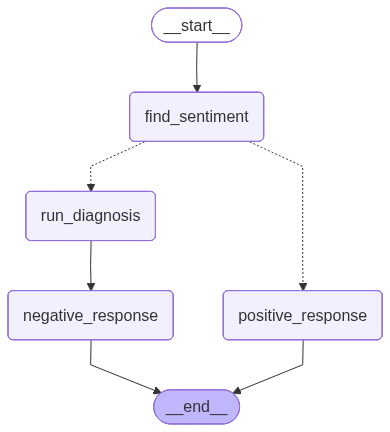

In [15]:
workflow

In [21]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "I understand you're experiencing a bug and are feeling frustrated, especially with the high urgency of this issue. I'm really sorry to hear that this is causing you trouble.\n\nPlease know that we're taking this very seriously and are working diligently to resolve it as quickly as possible. To help us pinpoint the exact problem and expedite a fix, could you please provide us with a few more details? Specifically, any information about:\n\n*   **What exactly is happening?** (e.g., error messages, unexpected behavior, specific actions that trigger the bug)\n*   **When did this issue start occurring?**\n*   **Are there any specific 